In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit,GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,root_mean_squared_error

In [2]:
x_train = pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\XTrain.csv")
y_train = pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\YTrain.csv")
engine = np.array(pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Engine.csv"))
Y_train=np.asarray(y_train).ravel()
Engine=engine.ravel()

In [3]:
xtest_data = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\XTest.csv')
ytest_data  = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Ytest.csv')
engine_test_data = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Engine_test.csv')

In [4]:
y_test=np.asarray(ytest_data).ravel()

In [5]:
print(len(Y_train))
y_train_clipped=np.clip(Y_train,a_min=None,a_max=130)
print(len(y_train_clipped))
print(len(y_test))
y_test_clipped=np.clip(y_test,a_min=None,a_max=130)
print(len(y_test_clipped))


20631
20631
13096
13096


In [40]:
gss_b = GroupShuffleSplit(n_splits = 1, train_size = 0.7, random_state = 42)
train_index_b,val_index_b=next(gss_b.split(x_train, y_train_clipped, engine))
xgb_b = XGBRegressor(learning_rate= 0.05,max_depth= 3,reg_lambda=30,min_child_weight= 100,n_estimators= 300)
xgb_b.fit(x_train.iloc[train_index_b,:], y_train_clipped[train_index_b])
prediction=xgb_b.predict(x_train.iloc[val_index_b,:])
print(r2_score( y_train_clipped[val_index_b],prediction))
print(root_mean_squared_error( y_train_clipped[val_index_b],prediction))
ypred = xgb_b.predict(xtest_data)
print('RMSE: ',np.sqrt(root_mean_squared_error(y_test_clipped, ypred)))
print('R2: ',r2_score(y_test_clipped, ypred))

0.8140793011404026
18.740722619905753
RMSE:  4.24247838205228
R2:  0.624152945807236


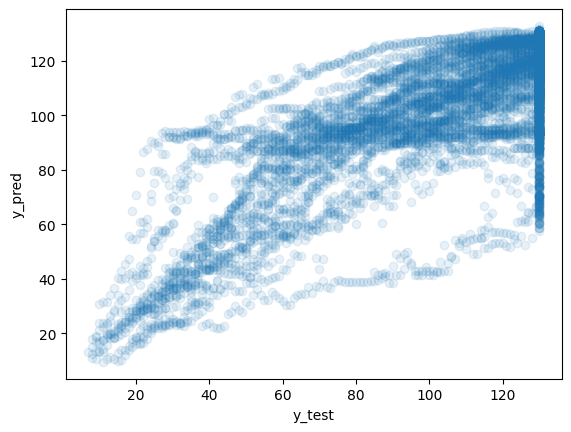

In [33]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter(y_test_clipped,ypred,alpha=0.1,marker="o")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [51]:
gss_outer = GroupShuffleSplit(n_splits = 10, train_size = 0.7, random_state = 42) #n_splits refers to number of folds required

# enumerate splits
outer_results = {"r2":[],"rmse":[]}
for i,(train_ix, test_ix) in enumerate(gss_outer.split(x_train, y_train_clipped, engine)):
    # split data
    X_train, X_test = x_train.iloc[train_ix, :], x_train.iloc[test_ix, :]
    Y_train, Y_test = y_train_clipped[train_ix], y_train_clipped[test_ix]
    Engine=engine[train_ix]
    
    Engine=Engine.ravel()
    # configure the cross-validation procedure
    gss_inner =  GroupShuffleSplit(n_splits = 3, train_size = 0.7, random_state = 42)
    # define the model
    xgb = XGBRegressor(seed=42)
    para={"learning_rate":[0.05,0.1,0.2],"n_estimators":[70,100,200,300],"max_depth":[3,4,5],"min_child_weight":[70,100,150,200],"reg_lambda":[30] }

    # define search
    search = GridSearchCV(xgb, param_grid=para, scoring=['r2','neg_root_mean_squared_error'], cv=gss_inner, refit='r2',n_jobs=2)
    # execute search
    result = search.fit(X_train, Y_train,groups=Engine)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    r2 = r2_score(Y_test, yhat)
    rmse=root_mean_squared_error(Y_test,yhat)
    # store the result
    outer_results["r2"].append(r2)
    outer_results["rmse"].append(rmse)
    # report progress
    print('>r2=%.3f, est=%.3f, cfg=%s' % (r2, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('R2: %.3f (%.3f)' % (np.mean(outer_results["r2"]), np.std(outer_results["r2"])))
print('RMSE: %.3f (%.3f)' % (np.mean(outer_results["rmse"]), np.std(outer_results["rmse"])))

>r2=0.821, est=0.785, cfg={'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 70, 'n_estimators': 100, 'reg_lambda': 30}
>r2=0.754, est=0.848, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70, 'reg_lambda': 30}
>r2=0.818, est=0.801, cfg={'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 70, 'reg_lambda': 30}
>r2=0.843, est=0.783, cfg={'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 70, 'n_estimators': 100, 'reg_lambda': 30}
>r2=0.850, est=0.791, cfg={'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 100, 'reg_lambda': 30}
>r2=0.768, est=0.806, cfg={'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 70, 'reg_lambda': 30}
>r2=0.824, est=0.785, cfg={'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 150, 'n_estimators': 70, 'reg_lambda': 30}
>r2=0.765, est=0.837, cfg={'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 100, 'n_esti

>r2=0.821, est=0.785, cfg={'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 70, 'n_estimators': 100, 'reg_lambda': 30}

>r2=0.754, est=0.848, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70, 'reg_lambda': 30}

>r2=0.818, est=0.801, cfg={'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 70, 'reg_lambda': 30}

>r2=0.843, est=0.783, cfg={'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 70, 'n_estimators': 100, 'reg_lambda': 30}

>r2=0.850, est=0.791, cfg={'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 100, 'reg_lambda': 30}

>r2=0.768, est=0.806, cfg={'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 70, 'reg_lambda': 30}

>r2=0.824, est=0.785, cfg={'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 150, 'n_estimators': 70, 'reg_lambda': 30}

>r2=0.765, est=0.837, cfg={'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 100, 'n_estimators': 200, 'reg_lambda': 30}

>r2=0.766, est=0.855, cfg={'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 100, 'reg_lambda': 30}

>r2=0.827, est=0.838, cfg={'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 200, 'n_estimators': 70, 'reg_lambda': 30}

R2: 0.804 (0.034)

RMSE: 19.169 (1.681)

In [56]:

pickle.dump(best_model, open('xgb_clipped_model.pkl','wb')) 

In [57]:
best_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=200, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=70, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)>

In [60]:
ypred=best_model.predict(xtest_data)
print(r2_score(y_test_clipped,ypred))
print(root_mean_squared_error(y_test_clipped,ypred))

0.650638950106402
17.35285519377179


testing accuracy

0.650638950106402

17.35285519377179

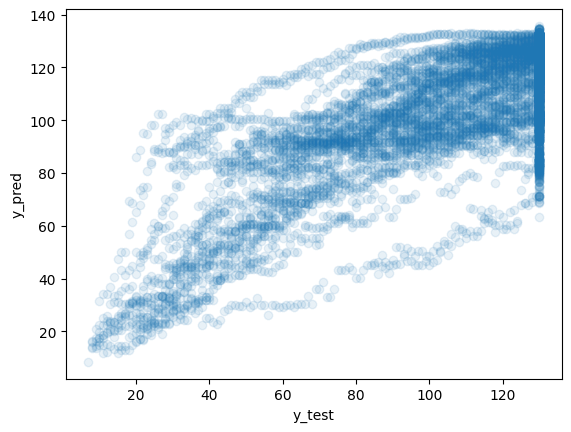

In [61]:
fig=plt.figure()
plt.scatter(y_test_clipped,ypred,alpha=0.1,marker="o")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()